In [2]:
using ITensorMPS
using ITensors
using Plots
using DelimitedFiles

# One-Particle Propogation

In [6]:
N_s = 12
cutoff = 1E-8

# Make an array of 'site' indices
s = siteinds("S=1/2", N_s)
# State Preparation
vacs = ["Up" for n = 1:N_s]
vac = MPS(s, vacs)
n_kr = 4

width_wp = 5
c = [-2, -1, 0, 1, 2]
x0 = 8
# println(x0)

state = MPS(s, vacs)

for xr in 1:width_wp
    pos = x0 + c[xr]
    # println(pos)
    pstate = MPS(s, vacs)

    rmom_exp = exp(-1im * n_kr * pi / N_s * pos)
    rgauss_exp = exp(- c[xr]^2 / (3/2)^2)
    rpref = rmom_exp * rgauss_exp
    
    # Apply CDAG[xr]
    pstate = apply(2 * op("S-", s[pos]), pstate; cutoff)
    if xr != 1
        for j in 1:(xr - 1)
            println(pos - j)
            pstate = apply(- op("Z", s[pos - j]), pstate; cutoff)
        end
    end

    normalize!(pstate)
    state += rpref * pstate
end
state -= vac
normalize!(state)

6
7
6
8
7
6
9
8
7
6


MPS
[1] ((dim=2|id=175|"S=1/2,Site,n=1"), (dim=2|id=952|"Link,l=1"))
[2] ((dim=2|id=609|"S=1/2,Site,n=2"), (dim=2|id=389|"Link,l=2"), (dim=2|id=952|"Link,l=1"))
[3] ((dim=2|id=393|"S=1/2,Site,n=3"), (dim=2|id=454|"Link,l=3"), (dim=2|id=389|"Link,l=2"))
[4] ((dim=2|id=74|"S=1/2,Site,n=4"), (dim=2|id=180|"Link,l=4"), (dim=2|id=454|"Link,l=3"))
[5] ((dim=2|id=739|"S=1/2,Site,n=5"), (dim=2|id=287|"Link,l=5"), (dim=2|id=180|"Link,l=4"))
[6] ((dim=2|id=443|"S=1/2,Site,n=6"), (dim=2|id=708|"Link,l=6"), (dim=2|id=287|"Link,l=5"))
[7] ((dim=2|id=879|"S=1/2,Site,n=7"), (dim=2|id=768|"Link,l=7"), (dim=2|id=708|"Link,l=6"))
[8] ((dim=2|id=954|"S=1/2,Site,n=8"), (dim=2|id=170|"Link,l=8"), (dim=2|id=768|"Link,l=7"))
[9] ((dim=2|id=538|"S=1/2,Site,n=9"), (dim=2|id=557|"Link,l=9"), (dim=2|id=170|"Link,l=8"))
[10] ((dim=2|id=975|"S=1/2,Site,n=10"), (dim=1|id=345|"Link,l=10"), (dim=2|id=557|"Link,l=9"))
[11] ((dim=2|id=871|"S=1/2,Site,n=11"), (dim=1|id=721|"Link,l=11"), (dim=1|id=345|"Link,l=10"))
[12] 

In [7]:
print(div(N_s, 2))

8

[0.0, 0.0, 5.551115123125783e-17, -1.1102230246251565e-16, -3.3306690738754696e-16, 0.01519962536588304, 0.2187517329435062, 0.5320972833812209, 0.2187517329435053, 0.015199625365883096, -4.440892098500626e-16, -4.440892098500626e-16, -4.440892098500626e-16, -4.440892098500626e-16, -4.440892098500626e-16, -4.440892098500626e-16]


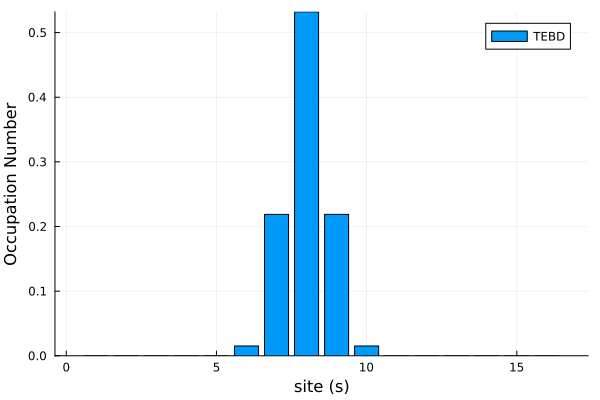

In [8]:
magz = expect(state, "Sz")
occs = [(1 - 2 * magz[n])/2 for n=1:N_s]
println(occs)

sites = [n for n=1:N_s]
plot(bar(sites, occs; label="TEBD"); xlabel="site (s)", ylabel="Occupation Number")

In [9]:
# Make Time-Evolution Gates
lam = 0.2

tau = 0.2

N_t = 300

gates = ITensor[]
for j in 1:N_s
    s1 = s[j]
    if j == N_s
        s2 = s[1]
    else
        s2 = s[j+1]
    end
    
    x1 = op("X", s1)
    x2 = op("X", s2)

    hxx = - lam * x1 * x2

    Gj = exp(-1im * tau / 2 * hxx)

    push!(gates, Gj)

    hz = - op("Z", s1)
    Gj = exp(-1im * tau / 2 * hz)
    push!(gates, Gj)
end

# Include gates in reverse order too
# (N,N-1),(N-1,N-2),...
append!(gates, reverse(gates))

64-element Vector{ITensor}:
 ITensor ord=4
Dim 1: (dim=2|id=175|"S=1/2,Site,n=1")
Dim 2: (dim=2|id=609|"S=1/2,Site,n=2")
Dim 3: (dim=2|id=175|"S=1/2,Site,n=1")'
Dim 4: (dim=2|id=609|"S=1/2,Site,n=2")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2×2
[:, :, 1, 1] =
 0.9998000066665779 + 0.0im  0.0 + 0.0im
                0.0 + 0.0im  0.0 + 0.019998666693333084im

[:, :, 2, 1] =
                0.0 + 0.0im  0.0 + 0.019998666693333084im
 0.9998000066665779 + 0.0im  0.0 + 0.0im

[:, :, 1, 2] =
 0.0 + 0.0im                  0.9998000066665778 + 0.0im
 0.0 + 0.01999866669333308im                 0.0 + 0.0im

[:, :, 2, 2] =
 0.0 + 0.01999866669333308im                 0.0 + 0.0im
 0.0 + 0.0im                  0.9998000066665778 + 0.0im
 ITensor ord=2
Dim 1: (dim=2|id=175|"S=1/2,Site,n=1")'
Dim 2: (dim=2|id=175|"S=1/2,Site,n=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
 0.9950041652780257 + 0.09983341664682814im  …                 0.0 + 0.0im
                0.0 + 0.0im    

In [10]:
# Compute and print <Sz> at each time step
# then apply the gates to go to the next time
maxdim = 20
occs = []
ttotal = N_t * tau
j = 0
for t in 0:tau:ttotal
    if mod(j, 100) == 0
        println(j)
    end
    j += 1
    # println("Pass 1")
    Sz = expect(state, "Sz")
    occ = [(1 - 2 * Sz[n])/2 for n=1:N_s]
    push!(occs, occ)


    t ≈ ttotal && break

    state = apply(gates, state; cutoff, maxdim)
    normalize!(state)
end

0
100
200
300


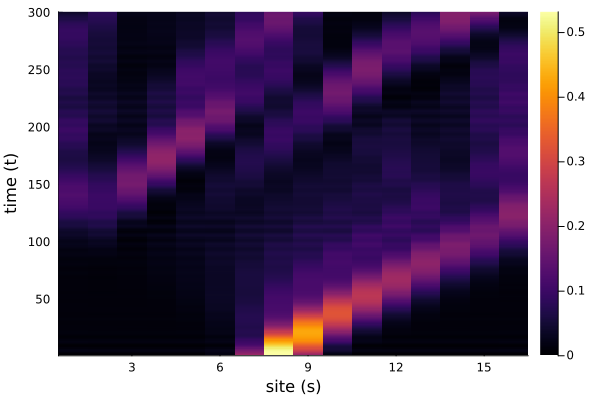

In [11]:
plot_times = zeros((N_t))
plot_occs = zeros((N_t, N_s))
for i in 1:N_t
    plot_times[i] = (i-1) * tau
    for j in 1:N_s
        plot_occs[i,j] = occs[i][j]
    end
end

plot_sites = zeros((N_s))
for i in 1:N_s
    plot_sites[i] = i
end

heatmap(plot_occs, xlabel="site (s)", ylabel="time (t)")

In [7]:
writedlm("N64-one-part-dmrg-lam0.2-dt0.04.txt", plot_occs)
# writedlm("N16-one-part-int-dmrg-lam02-eps01.txt", plot_occs)

# Two-Particle Scattering

In [3]:
N_s = 32
cutoff = 1E-8
# maxdim = 2

# Make an array of 'site' indices
s = siteinds("S=1/2", N_s)

# State Preparation
vacs = ["Up" for n = 1:N_s]
vac = MPS(s, vacs)
n_kr = 9
n_kl = -9
sigma = 3/2

width_wp = 5
c   = [-2, -1, 0, 1, 2]
xr0 = 11
xl0 = 21
xrs = [xr0 + c[n] for n=1:5]
xls = [xl0 + c[n] for n=1:5]

init_state = MPS(s, vacs)

for xr in 1:width_wp
    for xl in 1:width_wp
        pstate = MPS(s, vacs)

        r_pos = xrs[xr]
        rmom_exp = exp(-1im * n_kr * pi / N_s * r_pos)
        rgauss_exp = exp(- c[xr]^2 / (sigma)^2)
        rpref = rmom_exp * rgauss_exp
        
        # Apply CDAG[xr]
        pstate = apply(2 * op("S-", s[r_pos]), pstate; cutoff)
        if r_pos != 1
            for j in 1:(xr - 1)
                # println(pos - j)
                pstate = apply(- op("Z", s[xrs[j]]), pstate; cutoff)
            end
        end
        
        l_pos = xls[xl]
        lmom_exp = exp(-1im * n_kl * pi / N_s * l_pos)
        lgauss_exp = exp(- c[xl]^2 / (sigma)^2)
        lpref = lmom_exp * lgauss_exp
        pstate = apply(2 * op("S-", s[l_pos]), pstate; cutoff)
        if l_pos != 1
            for j in 1:(xl - 1)
                # println(pos - j)
                pstate = apply(- op("Z", s[xls[j]]), pstate; cutoff)
            end
        end
        pstate = apply(- op("Z", s[div(N_s, 2)]), pstate; cutoff)
        normalize!(pstate)
        init_state += lpref * rpref * pstate
    end
end
init_state -= vac
normalize!(init_state)

MPS
[1] ((dim=2|id=684|"S=1/2,Site,n=1"), (dim=2|id=18|"Link,l=1"))
[2] ((dim=2|id=927|"S=1/2,Site,n=2"), (dim=2|id=562|"Link,l=2"), (dim=2|id=18|"Link,l=1"))
[3] ((dim=2|id=640|"S=1/2,Site,n=3"), (dim=2|id=303|"Link,l=3"), (dim=2|id=562|"Link,l=2"))
[4] ((dim=2|id=756|"S=1/2,Site,n=4"), (dim=2|id=53|"Link,l=4"), (dim=2|id=303|"Link,l=3"))
[5] ((dim=2|id=278|"S=1/2,Site,n=5"), (dim=2|id=707|"Link,l=5"), (dim=2|id=53|"Link,l=4"))
[6] ((dim=2|id=344|"S=1/2,Site,n=6"), (dim=2|id=786|"Link,l=6"), (dim=2|id=707|"Link,l=5"))
[7] ((dim=2|id=683|"S=1/2,Site,n=7"), (dim=2|id=125|"Link,l=7"), (dim=2|id=786|"Link,l=6"))
[8] ((dim=2|id=132|"S=1/2,Site,n=8"), (dim=2|id=235|"Link,l=8"), (dim=2|id=125|"Link,l=7"))
[9] ((dim=2|id=728|"S=1/2,Site,n=9"), (dim=3|id=221|"Link,l=9"), (dim=2|id=235|"Link,l=8"))
[10] ((dim=2|id=694|"S=1/2,Site,n=10"), (dim=3|id=292|"Link,l=10"), (dim=3|id=221|"Link,l=9"))
[11] ((dim=2|id=890|"S=1/2,Site,n=11"), (dim=3|id=700|"Link,l=11"), (dim=3|id=292|"Link,l=10"))
[12] ((d

[0.0, -2.220446049250313e-16, -3.3306690738754696e-16, -7.771561172376096e-16, -6.661338147750939e-16, -4.440892098500626e-16, -1.1102230246251565e-16, -3.3306690738754696e-16, 0.015199625365884206, 0.2187517329435104, 0.5320972833812194, 0.21875173294350259, 0.015199625365883096, -1.1102230246251565e-16, -1.1102230246251565e-16, -1.1102230246251565e-16, 5.551115123125783e-17, 5.551115123125783e-17, 0.015199625365883485, 0.2187517329435053, 0.532097283381222, 0.2187517329435062, 0.015199625365883318, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


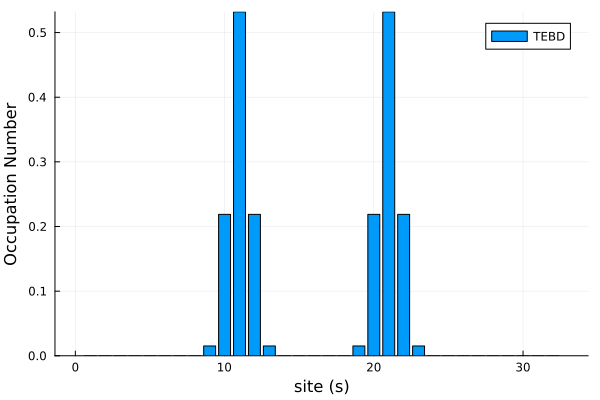

In [4]:
magz = expect(init_state, "Z")
occs = [(1 - magz[n])/2 for n=1:N_s]
println(occs)

sites = [n for n=1:N_s]
plot(bar(sites, occs; label="TEBD"), xlabel="site (s)", ylabel="Occupation Number")

In [5]:
println(magz)

[1.0, 1.0000000000000004, 1.0000000000000007, 1.0000000000000016, 1.0000000000000013, 1.0000000000000009, 1.0000000000000002, 1.0000000000000007, 0.9696007492682316, 0.5624965341129792, -0.0641945667624388, 0.5624965341129948, 0.9696007492682338, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 0.9999999999999999, 0.9999999999999999, 0.969600749268233, 0.5624965341129894, -0.064194566762444, 0.5624965341129876, 0.9696007492682334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [64]:
# Make Time-Evolution Gates
lam = 0.8
tau = 0.02
eps = 0.1
N_t = 400

gates = ITensor[]
for j in 1:N_s
    s1 = s[j]
    if j == N_s
        s2 = s[1]
    else
        s2 = s[j+1]
    end
    
    x1 = op("X", s1)
    x2 = op("X", s2)

    hxx = - lam * x1 * x2

    Gj = exp(-1im * tau / 2 * hxx)

    push!(gates, Gj)

    hz = - op("Z", s1)
    Gj = exp(-1im * tau / 2 * hz)
    push!(gates, Gj)

    z1 = op("Z", s1)
    z2 = op("Z", s2)

    hzz = - eps * z1 * z2

    Gj = exp(1im * tau / 2 * hzz)
    push!(gates, Gj)
end

# Include gates in reverse order too
# (N,N-1),(N-1,N-2),...
append!(gates, reverse(gates))

192-element Vector{ITensor}:
 ITensor ord=4
Dim 1: (dim=2|id=684|"S=1/2,Site,n=1")
Dim 2: (dim=2|id=927|"S=1/2,Site,n=2")
Dim 3: (dim=2|id=684|"S=1/2,Site,n=1")'
Dim 4: (dim=2|id=927|"S=1/2,Site,n=2")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2×2
[:, :, 1, 1] =
 0.9999680001706664 + 0.0im  0.0 + 0.0im
                0.0 + 0.0im  0.0 + 0.007999914666939733im

[:, :, 2, 1] =
                0.0 + 0.0im  0.0 + 0.007999914666939733im
 0.9999680001706664 + 0.0im  0.0 + 0.0im

[:, :, 1, 2] =
 0.0 + 0.0im                   0.9999680001706662 + 0.0im
 0.0 + 0.007999914666939733im                 0.0 + 0.0im

[:, :, 2, 2] =
 0.0 + 0.007999914666939733im                 0.0 + 0.0im
 0.0 + 0.0im                   0.9999680001706662 + 0.0im
 ITensor ord=2
Dim 1: (dim=2|id=684|"S=1/2,Site,n=1")'
Dim 2: (dim=2|id=684|"S=1/2,Site,n=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
 0.9999500004166652 + 0.009999833334166663im  …                 0.0 + 0.0im
                0.0 + 0.0

In [65]:
# Compute and print <Sz> at each time step
# then apply the gates to go to the next time
maxdim = 20
occs = []
ttotal = N_t * tau
state = init_state
for t in 0:tau:ttotal
    
    # println("Pass 1")
    Sz = expect(state, "Z")
    occ = [(1 - Sz[n])/2 for n=1:N_s]
    push!(occs, occ)


    t ≈ ttotal && break

    state = apply(gates, state; cutoff, maxdim)
    normalize!(state)
end

In [66]:
# sites = [n for n=1:N_s]
# for p in 1:length(occs)
#     if (p - 1) % 10 == 0
#         plt = plot(bar(sites, occs[p]; label="TEBD"); ylims= (0,0.6), xlabel="site")
#         png(plt, "Plots/plt" * string(p) * ".png")
#     end
# end

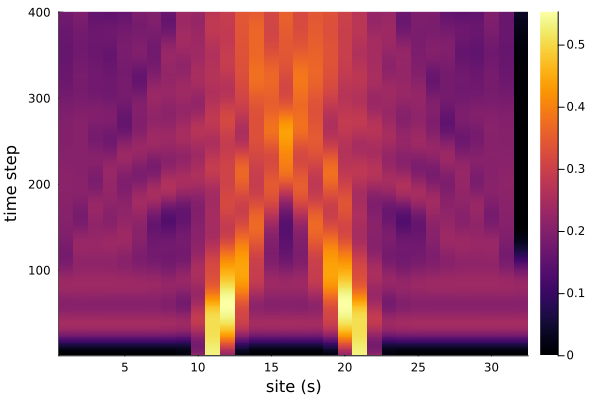

In [67]:
plot_times = zeros((N_t))
plot_occs = zeros((N_t, N_s))
for i in 1:N_t
    plot_times[i] = (i - 1) * tau
    for j in 1:N_s
        plot_occs[i,j] = occs[i][j]
    end
end

plot_sites = zeros((N_s))
for i in 1:N_s
    plot_sites[i] = i
end

heatmap(plot_occs, xlabel="site (s)", ylabel="time step")

In [70]:
title = "2-part-inter-N_s" * string(N_s)
title *= "-lam" * string(lam)
title *= "-eps" * string(eps)
title *= "-width" * string(sigma)
title *= "-dt" * string(tau) * ".txt"
writedlm(title, plot_occs)

In [71]:
println(title)

2-part-inter-N_s32-lam0.8-eps0.1-width1.5-dt0.02.txt
